In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

data_folder = '/kaggle/input/face-mask-detection/'



# Import dataset and create MaskDataset class 

In [2]:
## import os
from PIL import Image
from xml.etree import ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import transforms



class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, 'images')
        self.annot_dir = os.path.join(root_dir, 'annotations')
        self.transform = transform
        self.image_names = os.listdir(self.image_dir)
        self.image_names.sort()
#         self.size = size

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f'maksssksksss{idx}.png')
        image = Image.open(image_path).convert("RGB")
#         width, height = image.size
        image = self.transform(image)
        target = {}
        annot_path = os.path.join(self.annot_dir, f'maksssksksss{idx}.xml')
        tree = ET.parse(annot_path)
        root = tree.getroot()
#         size = root.find('size')

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            if label == 'with_mask':
                labels.append(1)
            elif label == 'without_mask':
                labels.append(2)
            elif label == 'mask_weared_incorrect':
                labels.append(3)
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels)
        target['boxes'] = boxes
        target['labels'] = labels
        return image, target
    
collate_fn = lambda batch: tuple(zip(*batch))
    

# create dataset and dataloader

# Define transforms for the dataset
train_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = MaskDataset(data_folder, transform=train_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)



/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Show a sample

In [3]:

img, target = next(iter(dataloader))
print(img[0].shape)
print(target[0])

torch.Size([3, 267, 400])
{'boxes': tensor([[ 22., 110.,  47., 136.],
        [105.,  86., 149., 143.],
        [146., 118., 182., 159.]]), 'labels': tensor([2, 1, 1])}


Let's now display some images with their corresponding bounding boxes colored by their label name

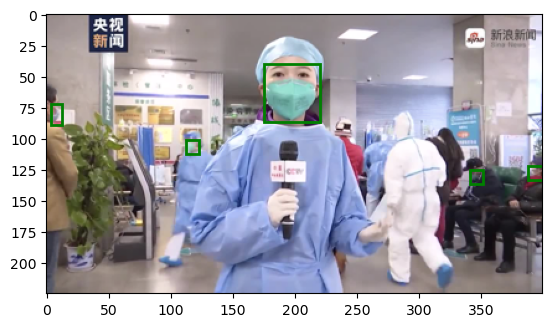

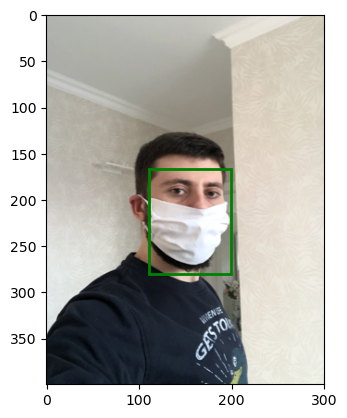

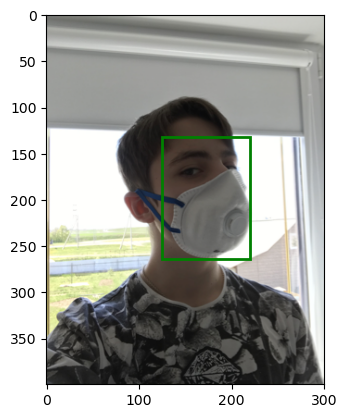

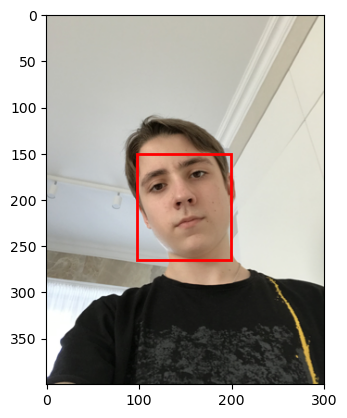

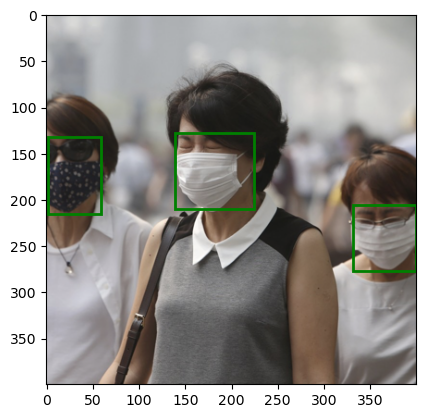

In [4]:
from matplotlib import pyplot as plt
from matplotlib import patches

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


def display_image(image, targets, dataset):
    fig, ax = plt.subplots(1)
    # Unnormalize the input image and convert it to a numpy array
    unnormalized_image = unorm(image).cpu().permute(1, 2, 0).numpy()
    ax.imshow(unnormalized_image)
    boxes = targets['boxes']
    labels = targets['labels']
    label_color = ['green', 'red', 'purple' ]
    for j, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=label_color[labels[j] - 1], facecolor='none')
        ax.add_patch(rect)
#         ax.text(xmin, ymin - 10, label_names[labels[j] - 1], fontsize=8, color='r')
    plt.show() 

for i, batch in enumerate(dataloader):
    if i == 3: # display images from the 4th batch
        for j in range(len(batch[0])):
            image = batch[0][j]
            targets = batch[1][j]
            display_image(image, targets, dataset)
            if j==4:
                break

# Model training 
Let's now split the dataset into training and test set

In [5]:
# Randomly split data into train part and test part
train_data_ratio = 0.95

train_size = int(len(dataset) * train_data_ratio)
test_size = len(dataset) - train_size # test data shouldn't be appeared in training

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))

Train data size:  810
Test data size:  43


We can train a Faster-RCNN model directly available from torchvision library. 

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [7]:
num_classes = 4
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


Let's define the optimizer and the scheduler for the learning rate 

In [8]:
# Define the optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4,
                              amsgrad=True, 
                              weight_decay=1e-6)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.5)

# Define the device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

We define a function for training on one epoch 

In [9]:
# Define the training loop
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader):
        # Sending training data to CUDA
        images = list([image.to(device) for image in images])
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if batch_idx % print_freq == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {losses}')

Let's train now 

In [10]:
# Define the number of epochs and batch size
num_epochs = 20
dataloader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
# Train the model
model.to(device)
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=20)
    lr_scheduler.step()

Epoch: 0, Batch: 0, Loss: 1.6919796466827393
Epoch: 0, Batch: 20, Loss: 0.49947842955589294
Epoch: 0, Batch: 40, Loss: 0.4132334887981415
Epoch: 0, Batch: 60, Loss: 0.13459190726280212
Epoch: 0, Batch: 80, Loss: 0.2843444347381592
Epoch: 0, Batch: 100, Loss: 0.17614445090293884
Epoch: 0, Batch: 120, Loss: 0.2593320906162262
Epoch: 0, Batch: 140, Loss: 0.17231117188930511
Epoch: 0, Batch: 160, Loss: 0.403717041015625
Epoch: 0, Batch: 180, Loss: 0.3380988836288452
Epoch: 0, Batch: 200, Loss: 0.35885384678840637
Epoch: 1, Batch: 0, Loss: 0.42955663800239563
Epoch: 1, Batch: 20, Loss: 0.33699387311935425
Epoch: 1, Batch: 40, Loss: 0.2860254943370819
Epoch: 1, Batch: 60, Loss: 0.3351719379425049
Epoch: 1, Batch: 80, Loss: 0.07535591721534729
Epoch: 1, Batch: 100, Loss: 0.2217758446931839
Epoch: 1, Batch: 120, Loss: 0.3406701683998108
Epoch: 1, Batch: 140, Loss: 0.12602776288986206
Epoch: 1, Batch: 160, Loss: 0.3864436745643616
Epoch: 1, Batch: 180, Loss: 0.18845851719379425
Epoch: 1, Batch:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


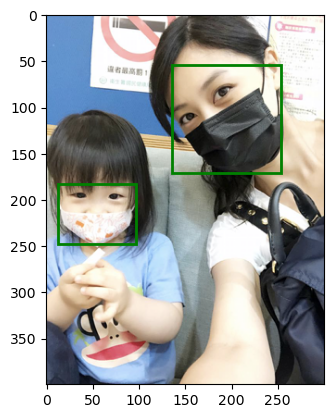

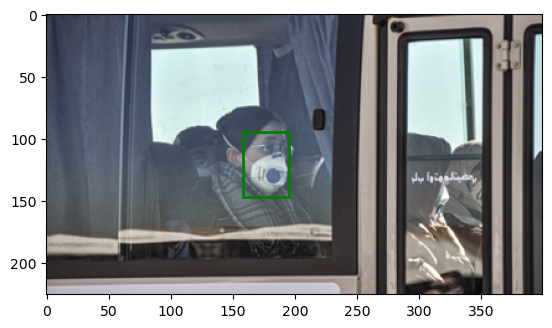

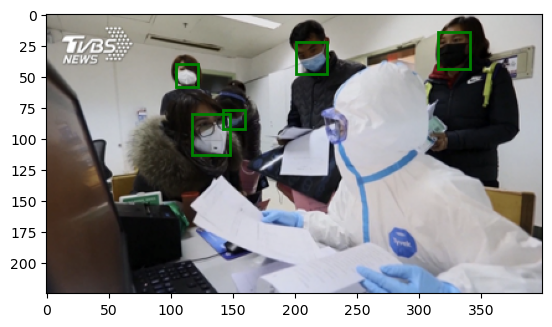

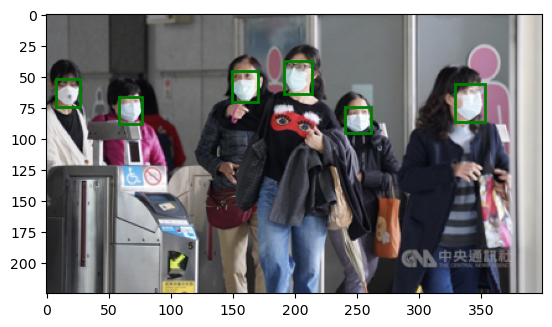

In [11]:
import torchvision.ops as ops
# Load a single minibatch of data
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

images, targets = next(iter(test_dataloader))

# Run the model on the minibatch of images
model.eval()
with torch.no_grad():
    images = list([image.to(device) for image in images])
    outputs = model(images)

    for i, image in enumerate(images):
        # Extract the predicted bounding boxes and labels for the current image
        boxes = outputs[i]['boxes'].cpu().numpy()
#         scores = outputs[i]['scores'].cpu().numpy()
        labels = outputs[i]['labels'].cpu().numpy()
        
        # Apply non-maximum suppression to remove duplicate detections
#         keep = ops.nms(torch.from_numpy(boxes), torch.from_numpy(scores), iou_threshold=0.1)

        # Keep only the top-scoring detections after NMS
#         boxes = boxes[keep]
# #         print(boxes.shape)
#         scores = scores[keep]
#         labels = labels[keep]

        # Visualize the input image with the predicted bounding boxes and labels
        fig, ax = plt.subplots(1)
        ax.imshow(unorm(image).cpu().permute(1, 2, 0))
        label_color = ['green', 'red', 'purple' ]

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box.astype(np.int)
            ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor=label_color[label - 1], linewidth=2))

        plt.show()